In [1]:
!python -m pip install --upgrade pip


In [2]:

!pip install yfinance pandas numpy matplotlib transformers streamlit


In [3]:
!pip install quantstats


In [18]:
import os
import pandas as pd
import yfinance as yf
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F

def load_market_data(symbols, start_date="2015-01-01", end_date="2024-01-01"):
    cache_file = "cached_data.csv"

    if os.path.exists(cache_file):
        print("✅ Loading data from cache...")
        raw = pd.read_csv(cache_file)
        return raw

    print("⏳ Downloading data from Yahoo Finance...")
    raw = yf.download(symbols, start=start_date, end=end_date, group_by="ticker", auto_adjust=True)

    if isinstance(raw.columns, pd.MultiIndex):
        raw = raw[symbols[0]].copy()

    raw = raw.reset_index()

    print("✅ Adding indicators...")

    # Technical Indicators
    raw['MA_18'] = raw['Close'].rolling(window=18).mean()
    raw['RSI_15'] = raw['Close'].rolling(window=15).apply(
        lambda win: 100 - (100 / (1 + (win.diff().clip(lower=0).sum() / (-win.diff().clip(upper=0).sum() + 1))))
    )
    raw['Daily_Return'] = raw['Close'].pct_change()

    print("🔎 Calculating FinBERT sentiment...")
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    model.eval()

    headlines = ["The stock market is stable."] * len(raw)
    sentiments = []

    for text in headlines:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            sentiment = (probs[:, 2] - probs[:, 0]).item()
            sentiments.append(sentiment)

    raw["Sentiment_Index"] = sentiments

    raw.dropna(inplace=True)

    # Save to cache
    raw.to_csv(cache_file, index=False)
    print("✅ Data saved to cache for next run.")

    return raw

def clean_preprocessed(df):
    df = df.copy()
    df.dropna(inplace=True)
    return df


In [19]:
symbols = ["AAPL"]
raw_df = load_market_data(symbols)
final_df = clean_preprocessed(raw_df)


[*********************100%***********************]  1 of 1 completed

⏳ Downloading data from Yahoo Finance...
✅ Adding indicators...


🔎 Calculating FinBERT sentiment...
✅ Data saved to cache for next run.


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import streamlit as st
import quantstats as qs

In [5]:
import yfinance as yf
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import torch

def load_market_data(symbols, start_date="2015-01-01", end_date="2024-01-01"):
    # Download data
    raw = yf.download(symbols, start=start_date, end=end_date, group_by="ticker", auto_adjust=True)

    if isinstance(raw.columns, pd.MultiIndex):
        raw = raw[symbols[0]].copy()

    raw = raw.reset_index()

    # Technical indicators
    raw['MA_18'] = raw['Close'].rolling(window=18).mean()  # changed from SMA 20
    raw['RSI_15'] = raw['Close'].rolling(window=15).apply(
        lambda win: 100 - (100 / (1 + (win.diff().clip(lower=0).sum() / (-win.diff().clip(upper=0).sum() + 1))))
    )
    raw['Daily_Return'] = raw['Close'].pct_change()

    # FinBERT Sentiment Analysis (dummy headlines)
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

    dummy_news = ["Market outlook remains optimistic amid economic signals"] * len(raw)
    sentiments = []

    for sentence in dummy_news:
        enc = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        out = model(**enc)
        prob = F.softmax(out.logits, dim=1)
        sentiments.append((prob[:, 2] - prob[:, 0]).item())  # Positive - Negative

    raw['Sentiment_Index'] = sentiments
    raw.dropna(inplace=True)

    return raw


def clean_preprocessed(df):
    df = df.copy()
    df.dropna(inplace=True)
    return df


In [14]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class StockSentimentEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, market_data, starting_funds=10000):
        super(StockSentimentEnv, self).__init__()
        self.market_data = market_data.reset_index(drop=True)
        self.initial_cash = starting_funds

        # Action space: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)

        # Observation: [Close, MA, RSI, Cash, Holdings, Sentiment]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.step_index = 0
        self.cash = self.initial_cash
        self.total_value = self.initial_cash
        self.shares = 0
        self.units_sold = 0
        self.sale_revenue = 0

        sentiment_score = self.market_data.loc[self.step_index, "Sentiment_Index"]

        obs = np.array([
            self.market_data.loc[self.step_index, "Close"],
            self.market_data.loc[self.step_index, "MA_18"],
            self.market_data.loc[self.step_index, "RSI_15"],
            self.cash,
            self.shares,
            sentiment_score
        ], dtype=np.float32)

        info = {}
        return obs, info

    def step(self, action):
        self._process_action(action)
        self.step_index += 1

        is_done = self.step_index >= len(self.market_data) - 1
        truncated = False

        sentiment_score = self.market_data.loc[self.step_index, "Sentiment_Index"]

        obs = np.array([
            self.market_data.loc[self.step_index, "Close"],
            self.market_data.loc[self.step_index, "MA_18"],
            self.market_data.loc[self.step_index, "RSI_15"],
            self.cash,
            self.shares,
            sentiment_score
        ], dtype=np.float32)

        reward = self.total_value - self.initial_cash

        info = {
            "portfolio_value": self.total_value,
            "cash": self.cash,
            "shares": self.shares
        }

        return obs, reward, is_done, truncated, info

    def _process_action(self, action):
        price_now = self.market_data.loc[self.step_index, "Close"]

        if action == 1 and self.cash > price_now:
            self.shares += 1
            self.cash -= price_now

        elif action == 2 and self.shares > 0:
            self.shares -= 1
            self.cash += price_now
            self.units_sold += 1
            self.sale_revenue += price_now

        self.total_value = self.cash + self.shares * price_now

    def render(self, mode="human"):
        print(f"[Step {self.step_index}] Cash: ₹{self.cash:.2f} | Holdings: {self.shares} | Net Worth: ₹{self.total_value:.2f}")

    def close(self):
        pass


In [15]:
import yfinance as yf
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

def load_market_data(symbols, start_date="2015-01-01", end_date="2024-01-01"):
    raw = yf.download(symbols, start=start_date, end=end_date, group_by="ticker", auto_adjust=True)

    if isinstance(raw.columns, pd.MultiIndex):
        raw = raw[symbols[0]].copy()

    raw = raw.reset_index()

    # Technical indicators
    raw['MA_18'] = raw['Close'].rolling(window=18).mean()
    raw['RSI_15'] = raw['Close'].rolling(window=15).apply(
        lambda win: 100 - (100 / (1 + (win.diff().clip(lower=0).sum() / (-win.diff().clip(upper=0).sum() + 1))))
    )
    raw['Daily_Return'] = raw['Close'].pct_change()

    # FinBERT sentiment analysis (optional)
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

    dummy_headlines = ["The stock market is stable."] * len(raw)
    sentiments = []
    for headline in dummy_headlines:
        inputs = tokenizer(
            headline,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=128
        )
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            sentiment = (probs[:, 2] - probs[:, 0]).item()  # pos - neg
            sentiments.append(sentiment)

    raw["Sentiment_Index"] = sentiments
    raw.dropna(inplace=True)

    return raw

def clean_preprocessed(df):
    df = df.copy()
    df.dropna(inplace=True)
    return df


In [20]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd

# Step 1: Load stock data and preprocess
symbols = ["AAPL"]
raw_df = load_market_data(symbols)
final_df = clean_preprocessed(raw_df)

# Step 2: Add dummy headlines (optional) for traceability
final_df["Headline"] = "The stock market is stable."

# Step 3: Use precomputed FinBERT scores already in 'Sentiment_Index'
# Update environment class to use precomputed scores (skip _extract_sentiment in step)

# Step 4: Train PPO Agent
vec_env = DummyVecEnv([lambda: StockSentimentEnv(final_df)])
ppo_agent = PPO("MlpPolicy", vec_env, verbose=1)
ppo_agent.learn(total_timesteps=10000)

# Step 5: Test the agent
portfolio_log = []
test_env = StockSentimentEnv(final_df)
obs, _ = test_env.reset()
finished = False

while not finished:
    action, _ = ppo_agent.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    portfolio_log.append(info['portfolio_value'])
    finished = terminated or truncated

# Step 6: Add portfolio values to DataFrame
final_df["Portfolio_Value"] = pd.Series(portfolio_log)

# Step 7: Save the trained agent
ppo_agent.save("ppo_stock_agent")


✅ Loading data from cache...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1730 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1339          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.6162132e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 5.49e+08      |
|    n_updates            | 10            |
|    policy_gradient_loss | -6.16e-05     |
|    value_loss           | 1.37e+09    

                           Strategy
-------------------------  ----------
Start Period               2015-01-28
End Period                 2023-12-29
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          688.28%
CAGR﹪                     17.32%

Sharpe                     0.94
Prob. Sharpe Ratio         99.75%
Smart Sharpe               0.87
Sortino                    1.38
Smart Sortino              1.28
Sortino/√2                 0.98
Smart Sortino/√2           0.91
Omega                      1.19

Max Drawdown               -38.52%
Max DD Date                2019-01-03
Max DD Period Start        2018-10-04
Max DD Period End          2019-10-09
Longest DD Days            617
Volatility (ann.)          29.01%
Calmar                     0.45
Skew                       -0.03
Kurtosis                   5.32

Expected Daily %           0.09%
Expected Monthly %         1.93%
Expected Yearly %          25.79%
Kelly Criterion            8.3%
Risk of Rui

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-04,2019-01-03,2019-10-09,371,-38.515897,-35.891204
2,2020-02-13,2020-03-23,2020-06-04,113,-31.427265,-29.938871
3,2022-01-04,2023-01-05,2023-06-01,514,-30.912821,-28.376355
4,2015-05-26,2016-05-12,2017-01-31,617,-30.443775,-28.611312
5,2020-09-02,2020-09-18,2020-12-24,114,-20.375608,-20.166930


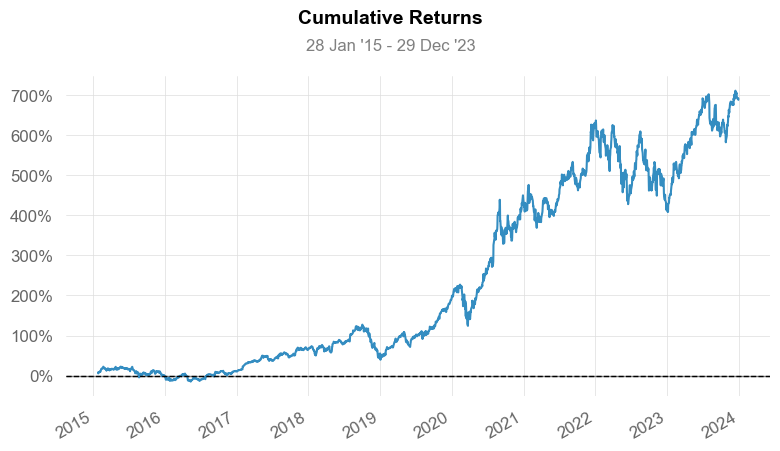

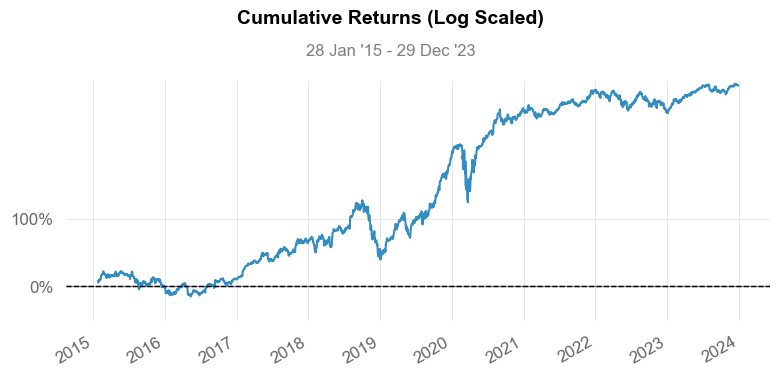

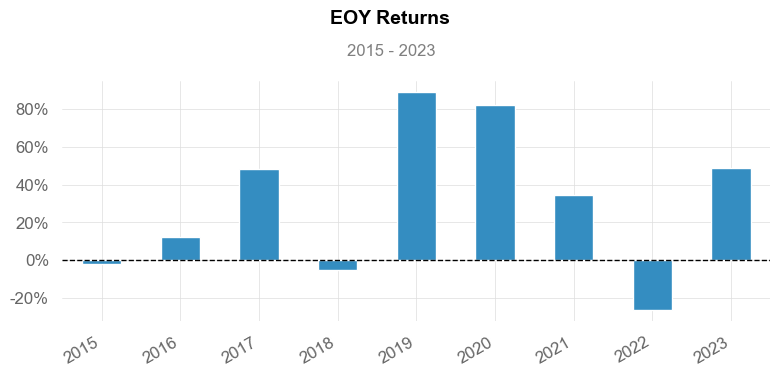

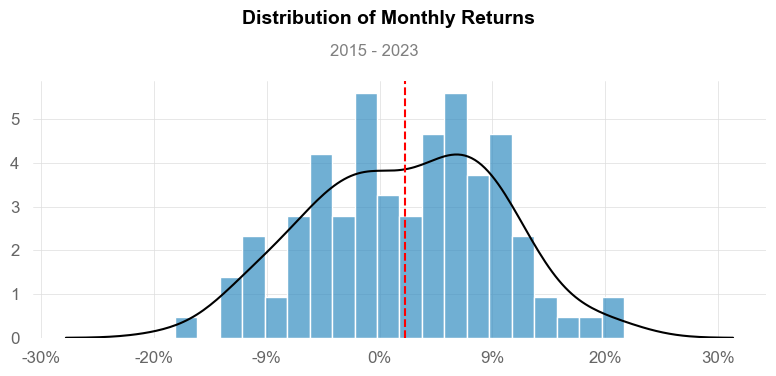

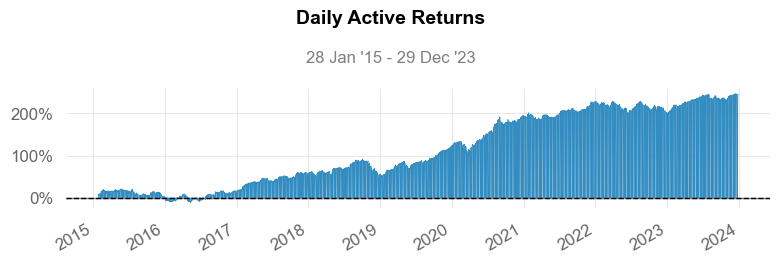

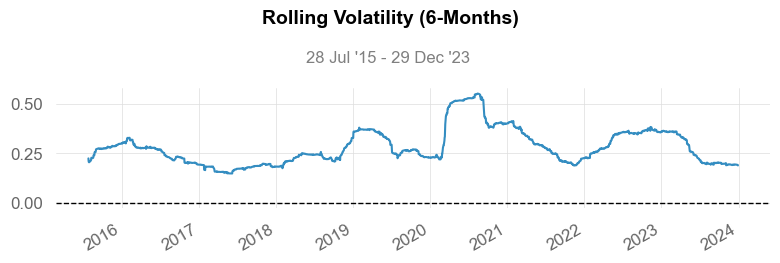

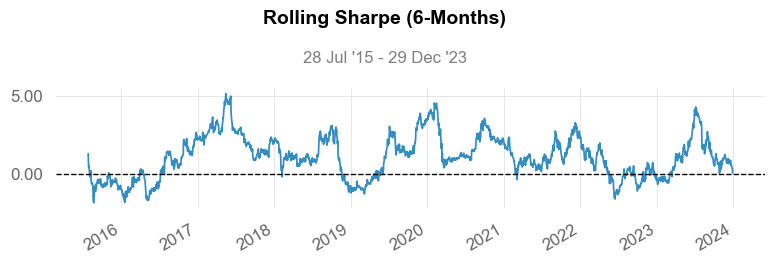

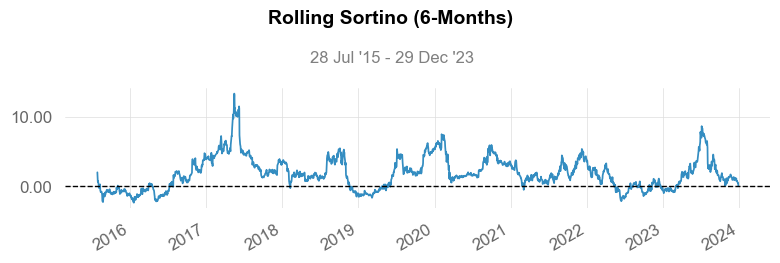

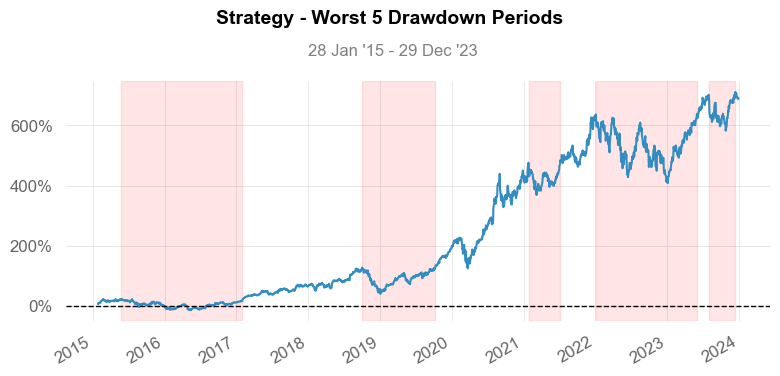

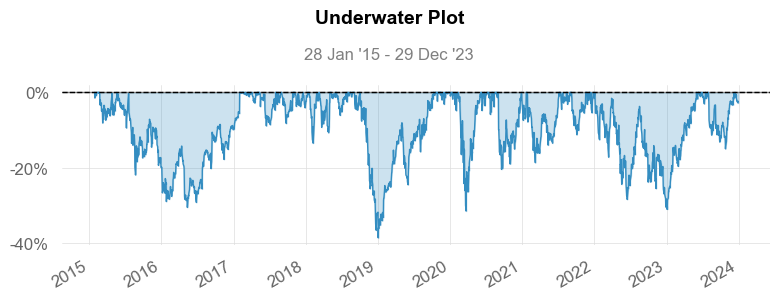

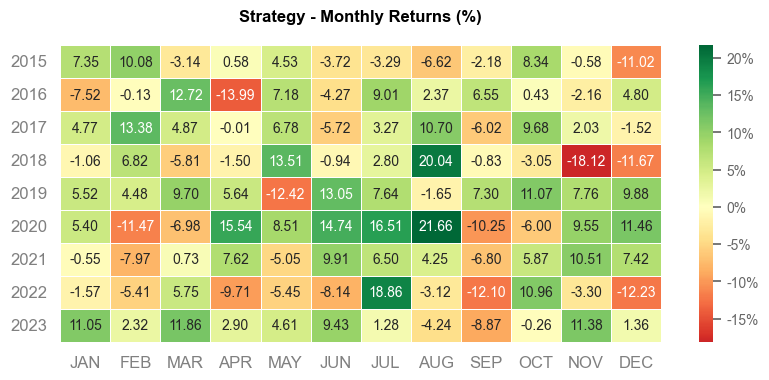

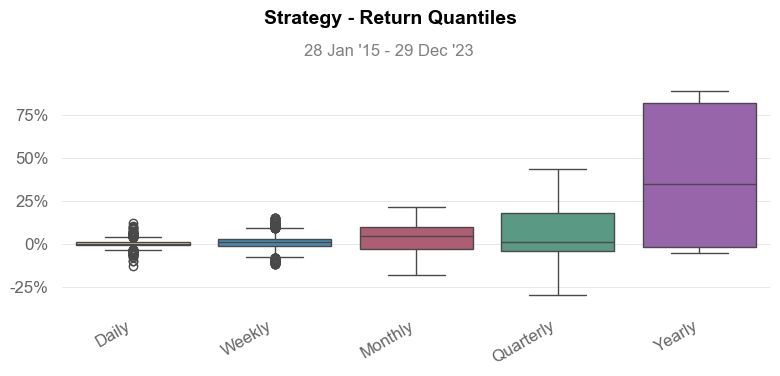

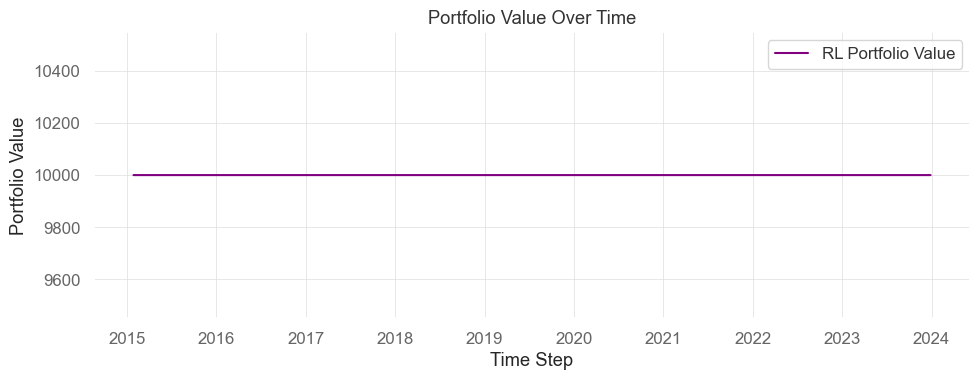

In [22]:
import quantstats as qs
import matplotlib.pyplot as plt

# 📅 Set datetime index
final_df["Date"] = pd.to_datetime(final_df["Date"])
final_df.set_index("Date", inplace=True)

# 📈 Use Daily_Return for QuantStats report (drop NaNs)
price_returns = final_df["Daily_Return"].dropna()

# 🧠 Generate full performance report
qs.reports.full(price_returns, title="PPO-Trained RL Agent Portfolio Performance")

# Optional: Show portfolio value plot
plt.figure(figsize=(10, 4))
plt.plot(final_df["Portfolio_Value"], label="RL Portfolio Value", color="purple")
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
